In [8]:
! export CUDA_VISIUAL_DEVICES="0,1,2,3,4,5,6,7"

In [9]:

import sys
import numpy as np
import staintools
import torch
from models import StainNet, ResnetGenerator
from PIL import Image 
import matplotlib.pyplot as plt

%matplotlib inline

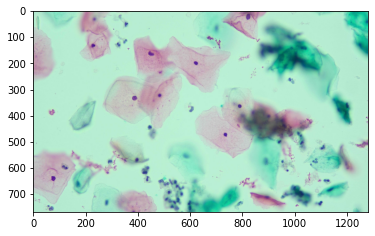

In [10]:
#read source image
# our_test = "transforms/stain_net/StainNet-master/assets/test_image.png"
# our_test = ".data/test_images/output.png"
our_test = "/nasdata/dataset/shishi_data/dt2/images/1589416469424.jpg"
img_source=Image.open(our_test).resize((1280, 768))
plt.imshow(img_source)


['/nasdata/dataset/wsi_patch_data/dt6/images/Ru4Gq1611580727916.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/NRmci1611580177823.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/NREXq1611580777926.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/JuYrX1611579928232.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/FQxrU1611580494840.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/FMT4Q1611580681304.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/JPbLx1611580318728.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/7Zvzi1611580169767.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/CWP3i1611580547352.jpg', '/nasdata/dataset/wsi_patch_data/dt6/images/QRBFL1611580587947.jpg']


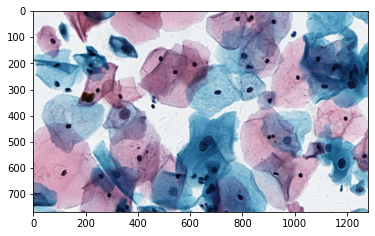

In [39]:
#read target image

# img_target=Image.open("transforms/stain_net/StainNet-master/assets/3_color_net_neg23570_target.png") 
from datasets.our_datasets import WSI_PATCH
import glob
images = glob.glob(WSI_PATCH.at("**/*.jpg"), recursive=True)
print(images[:10])
img_target=Image.open(images[121]) .resize((1280, 768))
plt.imshow(img_target)

In [12]:
#load  pretrained StainNet
# model_Net = StainNet().cuda()
# model_Net.load_state_dict(torch.load("transforms/stain_net/StainNet-master/checkpoints/aligned_cytopathology_dataset/StainNet-3x0_best_psnr_layer3_ch32.pth"))

In [13]:
def norm(image):
    image = np.array(image).astype(np.float32)
    image = image.transpose((2, 0, 1))
    image = ((image / 255) - 0.5) / 0.5
    image=image[np.newaxis, ...]
    image=torch.from_numpy(image)
    return image[:, :3, :, :]

def un_norm(image):
    image = image.cpu().detach().numpy()[0]
    image = ((image * 0.5 + 0.5) * 255).astype(np.uint8).transpose((1,2,0))
    return image


In [14]:
# run normlization
# image_net=model_Net(norm(img_source).cuda())
# image_net=un_norm(image_net)
# plt.imshow(image_net)

In [59]:
# load  pretrained StainGAN
model_GAN_A = ResnetGenerator(3, 3, ngf=64, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).cuda()
model_GAN_A.load_state_dict(torch.load("/nasdata/private/zwlu/Now/ai_trainer/transforms/stain_net/checkpoints/camelyon16_dataset/latest_net_G_A.pth"))
model_GAN_B = ResnetGenerator(3, 3, ngf=64, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).cuda()
model_GAN_B.load_state_dict(torch.load("/nasdata/private/zwlu/Now/ai_trainer/transforms/stain_net/checkpoints/camelyon16_dataset/latest_net_G_B.pth"))

<All keys matched successfully>

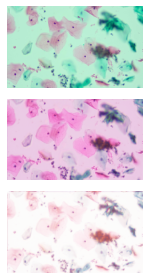

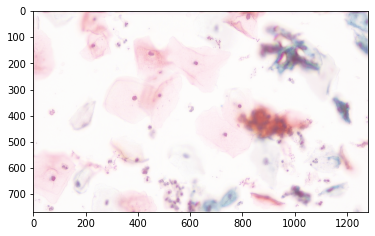

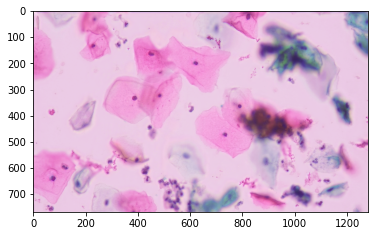

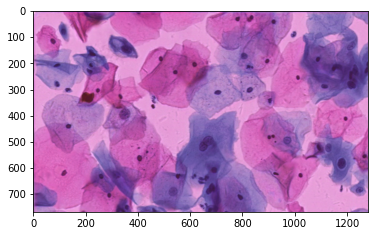

In [60]:
# run normlization
from tools.plot_utils import plot_many
# plt.imshow(img_source)
# plt.show()
image_gan=model_GAN_A(norm(img_source).cuda())
image_gan_reverse=model_GAN_B(image_gan)
image_gan=un_norm(image_gan)
image_gan_reverse=un_norm(image_gan_reverse)

# print(img_source)
plot_many([np.array(img_source), image_gan, image_gan_reverse], show=True, cols=1, dpi=300)

image_gan2 = model_GAN_A(norm(img_target).cuda())
image_gan2=un_norm(image_gan2)

plt.imshow(image_gan_reverse)
plt.show()
plt.imshow(image_gan)
plt.show()
plt.imshow(image_gan2)
plt.show()

reinhard


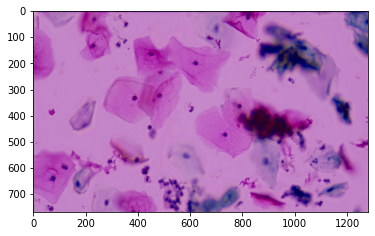

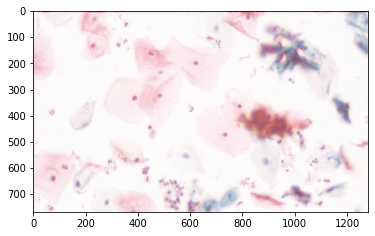

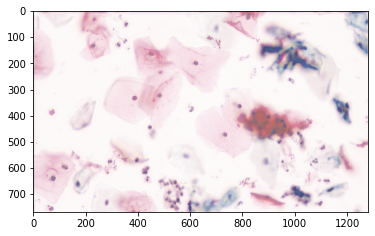

In [61]:
# use reinhard to transform the color
print("reinhard")
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(image_gan2)
reinhard_normalized = normalizer.transform(image_gan)
plt.imshow(reinhard_normalized)
plt.show()

image_gan_3=model_GAN_B(norm(image_gan).cuda())
image_gan_3=un_norm(image_gan_3)
plt.imshow(image_gan_3)
plt.show()

image_gan_3=model_GAN_B(norm(reinhard_normalized).cuda())
image_gan_3=un_norm(image_gan_3)
plt.imshow(image_gan_3)
plt.show()

reinhard


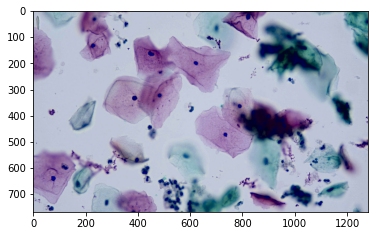

In [62]:
# run reinhard normlization
print("reinhard")
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(np.array(img_target))
reinhard_normalized = normalizer.transform(np.array(img_source))
plt.imshow(reinhard_normalized)

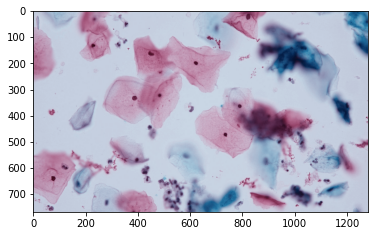

In [40]:
# run macenko normlization
normalizer = staintools.StainNormalizer(method="macenko")
normalizer.fit(np.resize(np.array(img_target), (512, 512, 3)))
macenko_normalized = normalizer.transform(np.array(img_source))
plt.imshow(macenko_normalized)

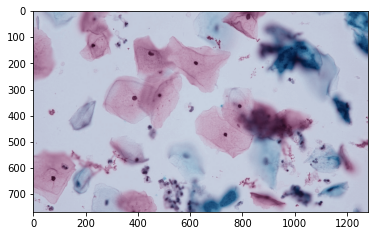

In [41]:
# run vahadane normlization
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(np.resize(np.array(img_target), (512, 512, 3)))
vahadane_normalized = normalizer.transform(np.array(img_source))
plt.imshow(vahadane_normalized)